In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

from __future__ import division
from import_file import *
load_libs()

In [2]:
# mpl.rcParams['figure.figsize'] = 3,3

# 1. Data Wrangling

In [3]:
data = []
for year in range(2010,2014):
    file = "./data/movie_list_%s_v2.json" % year
    with open(file, encoding='utf-8' ) as data_file:    
        data += json.load(data_file)
    
df = pd.DataFrame(data)
df.head()

,detail_url,douban_info,movie_tt_id,name,omdb_info
0,http://www.movieinsider.com/m4120/daybreakers/,"{'ratings_count': 22650, 'genres': ['剧情', '动作'...",tt0433362,Daybreakers,"{'Plot': 'In the year 2019, a plague has trans..."
1,http://www.movieinsider.com/m2104/youth-in-rev...,"{'ratings_count': 6796, 'genres': ['喜剧', '剧情',...",tt0403702,Youth in Revolt,{'Plot': 'While his trailer trash parents teet...
2,http://www.movieinsider.com/m5188/leap-year/,"{'ratings_count': 56719, 'genres': ['喜剧', '爱情'...",tt1216492,Leap Year,{'Plot': 'Anna Brady plans to travel to Dublin...
3,http://www.movieinsider.com/m4682/crazy-on-the...,"{'ratings_count': 2227, 'genres': ['喜剧', '家庭',...",tt1196134,Crazy on the Outside,{'Plot': 'A recently paroled ex-con who has tr...
4,http://www.movieinsider.com/m6816/bitch-slap/,"{'ratings_count': 2804, 'genres': ['动作', '喜剧',...",tt1212974,Bitch Slap,{'Plot': 'Three bad girls travel to a remote d...


In [4]:
# Problem, handling unicode json
df.drop_duplicates('movie_tt_id', inplace=True)
df['temp_string'] = df['douban_info'].astype(str)
df.drop_duplicates('temp_string', inplace=True)
df['temp_string'] = df['omdb_info'].astype(str)
df.drop_duplicates('temp_string', inplace=True)
df = df.dropna()
df.drop('temp_string', 1, inplace=True)
df.drop('detail_url', 1, inplace=True)

In [5]:
df['omdb_info'][0]

{'Actors': "Harriet Minto-Day, Jay Laga'aia, Damien Garvey, Sahaj Dumpleton",
 'Awards': '4 wins & 5 nominations.',
 'Country': 'Australia, USA',
 'Director': 'Michael Spierig, Peter Spierig',
 'Genre': 'Action, Fantasy, Horror',
 'Language': 'English',
 'Metascore': '57',
 'Plot': 'In the year 2019, a plague has transformed almost every human into vampires. Faced with a dwindling blood supply, the fractured dominant race plots their survival; meanwhile, a researcher works with a covert band of vamps on a way to save humankind.',
 'Poster': 'http://ia.media-imdb.com/images/M/MV5BNzg3NDYyMDU4Nl5BMl5BanBnXkFtZTcwODA5NzA5Mg@@._V1_SX300.jpg',
 'Rated': 'R',
 'Released': '8 Jan 2010',
 'Response': 'True',
 'Runtime': '98 min',
 'Title': 'Daybreakers',
 'Type': 'movie',
 'Writer': 'Michael Spierig, Peter Spierig',
 'Year': '2009',
 'imdbID': 'tt0433362',
 'imdbRating': '6.5',
 'imdbVotes': '98623'}

In [6]:
# Data problems
# 1.['imdb_info']['imdbRating'] do not exist
# 2.['imdb_rating'] is 'N/A', at id 108, 273
# 3.['imdb_rating'] is '23,421', need to get rid of the comma

df['imdb_rating'] = df['omdb_info'].apply(lambda x: x.get('imdbRating', np.nan))
df['metascore'] = df['omdb_info'].apply(lambda x: x.get('Metascore', np.nan))
df = df.dropna()
df = df[(df.imdb_rating != 'N/A') &(df.metascore != 'N/A')]
df['imdb_ratings_count'] = df['omdb_info'].apply(lambda x: int(x['imdbVotes'].replace(',', '')))
df['db_rating'] = df['douban_info'].apply(lambda x: x['rating']['average'])
df['db_ratings_count'] = df['douban_info'].apply(lambda x: x['ratings_count'])
df['imdb_rating'] = df['imdb_rating'].astype(float)
df['imdb_ratings_count'] = df['imdb_ratings_count'].astype(float)
# df['name'] = df['name'].apply(lambda x: x.encode('ascii','ignore'))
df['metascore'] = df['metascore'].astype(float)
df['metascore'] = df['metascore']/10
df['genre']=df['omdb_info'].apply(lambda x: x.get('Genre', 'none'))
df['image_url']=df['omdb_info'].apply(lambda x: x.get('Poster', 'none'))
df['douban_url']=df['douban_info'].apply(lambda x: x['alt'])

df.drop('douban_info', 1, inplace=True)
df.drop('omdb_info', 1, inplace=True)

# 2. Movie Overview

In [7]:
df.describe()

,imdb_rating,metascore,imdb_ratings_count,db_rating,db_ratings_count
count,1662.000000,1662.000000,1.662000e+03,1662.000000,1662.000000
mean,6.386282,5.514019,5.268382e+04,5.901986,18715.155235
std,0.988046,1.703777,1.050602e+05,2.532974,46304.546623
min,1.600000,0.100000,1.200000e+01,0.000000,0.000000
25%,5.800000,4.300000,1.895500e+03,5.800000,131.500000
50%,6.500000,5.550000,9.648000e+03,6.600000,2010.500000
75%,7.100000,6.700000,5.588025e+04,7.500000,12730.750000
max,8.900000,10.000000,1.255291e+06,9.300000,586362.000000


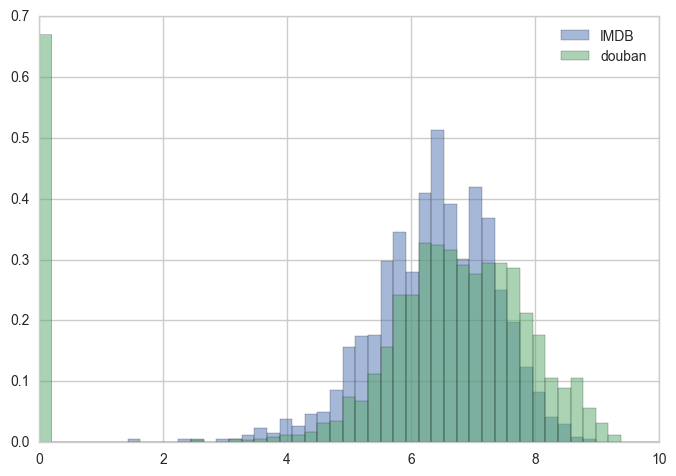

In [8]:
bins=linspace(0,10)
df['imdb_rating'].hist(bins=bins, alpha=0.5, normed=True, label = 'IMDB')
df['db_rating'].hist(bins=bins, alpha=0.5,  normed=True, label = 'douban')
plt.legend()

可以发现，有的电影豆瓣电影没有分数。应该把这些去掉

（可以看看这些电影是什么样的）

## 2.1 Empty Score Moives

In [9]:
empty_df = df.query('db_rating == 0')
display(empty_df.describe())
fig=plt.figure()
empty_df['imdb_rating'].hist(bins=arange(-0.05,10,0.1), alpha=0.5)
plt_configure(title='No Douban rating, IMDB Rating Distribution',figsize=(3,2))
fig=plt.figure()
empty_df['imdb_ratings_count'].hist(bins=50)
plt_configure(title='No Douban rating, IMDB Rating Count Distribution', figsize=(3,2))
align_figures()

,imdb_rating,metascore,imdb_ratings_count,db_rating,db_ratings_count
count,227.000000,227.000000,227.000000,227.0,227.000000
mean,6.070925,5.250220,628.911894,0.0,7.048458
std,1.137316,1.645465,1053.300889,0.0,6.173906
min,2.300000,0.900000,12.000000,0.0,0.000000
25%,5.500000,4.150000,168.500000,0.0,2.000000
50%,6.200000,5.400000,391.000000,0.0,5.000000
75%,6.900000,6.500000,726.000000,0.0,12.000000
max,8.400000,8.600000,13492.000000,0.0,23.000000


<img style="margin:0" align="left" src="data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAVUAAADWCAYAAABhXxHsAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAPYQAAD2EBqD+naQAAIABJREFUeJzt3XlYE+f2B/Bv2BEQEdlELWqtCAIiAiouFVGLu71traJV
r0pVlHqlVsBdUVG0uKDI4k61WC217tal6rUoFq9LrRsguCKLyKIhMWF+f/DLlCFhCQQm0fN5Hp6Q
yeSdM0tO3lkyR8AwDANCCCEqocV3AIQQ8i6hpEoIISpESZUQQlSIkiohhKgQJVVCCFEhSqqEEKJC
lFQJIUSFKKkSQogKUVIlhBAVUiqpjh8/Ho6Ojrh9+7bC1729vRESElLvoLy9vWFvb8/+OTg4wN3d
HWPHjsWhQ4fq3X5VNm3aBHt7+wZrvyGJxWKsWrUKR44cYYeFhISgf//+vMU0fvx4fPXVV+zzqKgo
2Nvbw8XFBa9fv1b4nn379sHe3p4Td0hICGd76NSpE1xdXTFs2DBs3rwZIpGI00bl8e3t7eHm5obR
o0fjt99+qzHuytufbBv08PCAn58fLl68qPSyOHv2LObNm8c+T0lJgb29Pa5evap0W8qSTavin5OT
E/r06YOgoCCkp6dzxk9KSkKnTp3w7NmzWrVfXFyMefPm4c8//6x2vKdPn8Le3h6//PILAODnn3+G
vb19radTHT6Xb2U6yr6hrKwMwcHBSEpKgo6O0m+vtY8//hgzZswAAEgkErx8+RLHjx/HvHnzcPfu
Xc4CVBWBQACBQKDydhtDbm4udu3ahfDwcHbYjBkzMGHCBB6jUkwikeDcuXMYOnSo3GvHjh1TuA4s
LCywefNmAOXbYHFxMf7880/ExMTg0qVL2LlzJ/T09Kocv7CwEEeOHEFgYCC2b9+OHj16VBtjxe1P
FvOjR48QExODGTNm4MCBA+jYsWOt53nHjh2c+XJ0dMT+/fvRvn37WrdRHwKBAIsXL4aDgwMAoLS0
FI8ePUJ8fDw+++wz7Nq1C87OzgDK5z0xMREWFha1avvOnTs4dOgQPvvss2rHs7CwwP79+9G6dWs2
JlV93vhevhUpnRVNTEyQlpaGqKgozJ49uyFiAgCYmZmxK1nGx8cHFhYW2LlzJwYOHAhXV9cGm76m
UXQLB9nGq266du2K48ePyyXVnJwcpKamolOnTigsLOS8pqenJ7c99O7dG87OzggICMCOHTvw9ddf
Vzt+3759ce3aNSQmJtaYVBVtf127doWzszMGDx6Mw4cPK5VUKzMyMpJrv6G1b9+eM00PDw988skn
GDVqFIKDg3H06FEIBAKYmZnBzMys1u0yDFOr5KhonTQUPpavjNLHVO3t7TFy5EjEx8fj77//rnbc
srIy/PDDDxg2bBhcXFzQr18/rFu3DmKxuM4Bz5w5E3p6evjxxx/ZYWKxGJs3b4avry+cnZ0xaNAg
xMXFcRKNokMTVe1+nD59GoMGDYKzszO++OILJCcnc16/d+8eZs2ahR49eqBz587o06cPwsLCOPNl
b2+PvXv3YsGCBfD09ETXrl0xe/ZsvHz5ssp5k+0e7dy5E76+vnB1dUVSUhIbk5+fH7p27QonJyf4
+vrihx9+YN/n4+MDgUCA4OBgdtc5ODgY3t7enGWwadMmrFmzBl5eXnBxccGUKVOQlZXFiSMpKQlD
hgyBs7MzRo4cieTkZDg6OrK7bfUhEAjg6+uLixcvyh0COHHiBNq1a6dUsurfvz+6dOnC2R6qY2Ji
Uq/ekYmJCQBw2nj69Cm+++479O7dG507d0bPnj0xb9489oth/PjxuHr1KlJSUtCpUyf2/4q7p1FR
URg4cCDOnz+P4cOHw8nJCYMGDZI73JWRkYGpU6fCzc0NvXr1QmRkJEJDQzF+/Pg6zY+xsTGmTJmC
hw8f4sqVKwDkPxcvX75EUFAQevXqxW4Tsm0hJSWF3RuqeLhn/PjxmDt3LgIDA+Hq6orJkyfL7f7L
pKamYtSoUXBycsKwYcNw7Ngx9rWqduMrT6um5QsAt27dwpQpU+Dp6Qk3NzdMmzYNaWlpctNKTk7G
5MmT0aVLF/Tq1Qtr165V2GmpSp1OVIWGhsLMzAwhISGQSCRVjrdw4UKEh4dj0KBB2Lp1K8aNG4eE
hATObpWyjI2N4ezsjNTUVHbY119/je3bt2P06NGIiYnBJ598gvXr12Px4sXVtqVo94NhGCxYsAAT
J07Epk2bYGxsjKlTp7LHkXNzc+Hn5wehUIjw8HDExcVhyJAhSEhIwK5duzhtrV+/HmVlZYiMjMS8
efNw7tw5rFixosZ5jIqKgr+/P9asWYOePXvi999/x8yZM+Hk5ITo6GhERUWhTZs2CAsLw82bN2Fp
aYmoqCgwDIMZM2awu72K5m/37t3IyMhAeHg4VqxYgb/++otzKOWXX35BSEgI3NzcEB0djUGDBiEg
IABlZWU1xl1bn3zyCaRSKc6dO8cZfuzYMQwZMkTp9ry8vJCdnY3nz59zhkulUkilUkgkErx69Qq7
d+9GWloaxo4dW6t2Ze+XSqUoLS3FnTt38N1330FXV5eNs7S0FOPHj8fDhw+xZMkSbN++HRMmTMDR
o0cRGRkJAFiyZAkcHBzg4OCAxMREdhe88rrJzc3F8uXLMXHiRMTGxqJVq1YIDg7Gw4cPAQAFBQXw
8/NDdnY2Vq9ejfnz5+PkyZM4cuRIvb4ovLy8wDAM+5mqvN3MnTsXDx8+xLJlyxAfHw8HBweEhIQg
JSUFjo6OWLRoETufFT9zx48fh7GxMaKjozFlyhSF02YYBosWLcLgwYMRHR2Njz76CHPmzMGZM2fY
cWqat9os38uXL2PMmDEQCATstp+dnY0vv/ySXb4V57dbt26IiYnBsGHDEB8fj59++qk2ixJAHXb/
gfJv62XLlmH69OnYvHkzvvnmG7lx0tLScPDgQXz77bfsAu3RowcsLCzw3Xff4cKFC+jTp09dJo8W
LVrg1q1bAIDz588jOTkZkZGR8PX1ZadjYGCAjRs3YsKECUodVxEIBFi+fDkGDBjAttW/f3/ExsZi
w4YNuH//Pjp16oRNmzbB0NCQHefSpUtISUnB1KlT2bY6duyIlStXss9v3LiBkydP1hjD4MGDMWrU
KPb5kSNH8OmnnyI4OJgd1qVLF3h6euLKlStwdnZGp06dAABt2rSp9mSbqakpoqOj2Q0uKysLUVFR
KCwshKmpKTZu3Ij+/ftj2bJlAMo/cNra2myCUIXmzZvD3d2dcwjg6dOnuHnzJiIiIrBlyxal2mvR
ogWA8qRkY2PDtufo6MgZTyAQYMyYMXB3d6+xzaSkJHYvQUZHRwdOTk7YsWMHu4wzMzPRsmVLrF69
Gra2tgDKd6uvX7+OlJQUAOW73UZGRhAIBJxd0sq9n9LSUqxYsQKenp4AADs7O/Tr1w/nz59H27Zt
sXv3bgiFQuzYsYOdZxcXFwwaNKh2C6oKsmOneXl5Cl+/evUqZs6cye71eHh4wMzMDHp6ejAyMsKH
H37IzmfFz5quri6WLl0KXV1dAOXrRJFvvvkGEydOBAD06tULDx8+RHR0dK1PstZm+a5btw5t27ZF
bGwsu+17eXnBx8cHGzdu5Gzfo0ePxvTp0wEAnp6e+O2333Du3Dl88cUXtYqnzmea+vXrh+HDhyMu
Lg4DBw5kP9QyKSkpEAgEcj2PIUOGsN9ydU2qFY/hpKSkQEdHB5988glnnOHDh2PDhg1ISUlRKqnq
6OiwCRUoPw7Up08f/P777wDKV4SXlxckEgnS09ORlZWF+/fv4+XLl3LHoVxcXDjPra2tIRQKa4yh
8u7v5MmTAQBv3rzBw4cPkZWVhb/++gsAlD6U4uTkxPkGt7a2BgAIhUIUFhbi2bNncsfKhw4diu+/
/16p6dRk8OD

In [10]:
# these 2 table can be combined with an interactive table sorting
# empty_df.sort_values(by='imdb_rating',ascending=False).head()

In [11]:
empty_df.sort_values(by='imdb_ratings_count',ascending=False).head()

,movie_tt_id,name,imdb_rating,metascore,imdb_ratings_count,db_rating,db_ratings_count,genre,image_url,douban_url
1318,tt1520498,The Oogieloves in the Big Balloon Adventure,7.2,3.2,13492.0,0.0,0,"Adventure, Family",http://ia.media-imdb.com/images/M/MV5BMTk0ODM0...,http://movie.douban.com/subject/4067243/
208,tt1396557,Winnebago Man,7.2,7.1,3564.0,0.0,12,"Documentary, Biography, Comedy",http://ia.media-imdb.com/images/M/MV5BMjEzNzg5...,http://movie.douban.com/subject/3794525/
1945,tt1662293,Nothing Left to Fear,4.4,1.2,3388.0,0.0,17,Horror,http://ia.media-imdb.com/images/M/MV5BMTU3NjE5...,http://movie.douban.com/subject/10546739/
1442,tt2112293,The Comedy,6.4,4.6,3049.0,0.0,11,Drama,http://ia.media-imdb.com/images/M/MV5BMjA0OTA3...,http://movie.douban.com/subject/7015721/
1369,tt1606829,The Other Dream Team,8.4,6.9,2927.0,0.0,23,"Documentary, Sport",http://ia.media-imdb.com/images/M/MV5BODg5MzQ3...,http://movie.douban.com/subject/5155675/


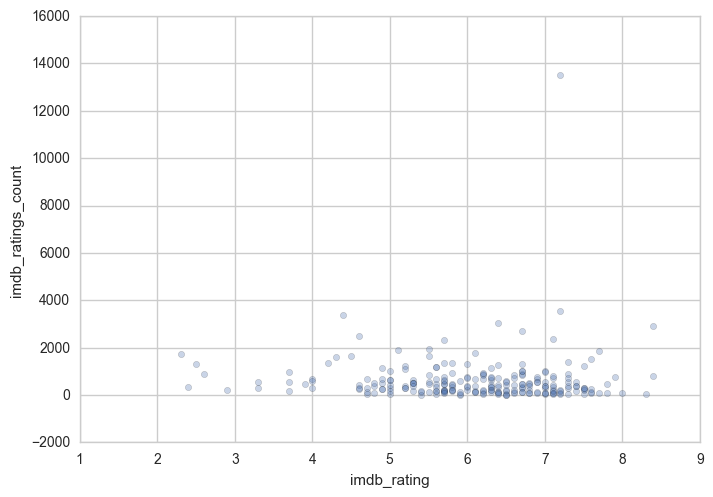

In [12]:
empty_df.plot(kind='scatter', x='imdb_rating', y='imdb_ratings_count', alpha=0.30)

## 2.2 Delete Empty movies, Go ahead

In [13]:
df = df.query('db_rating > 0')

# 3. Movie Overview (两种评分都有的)

## 3.1 Overall Info

In [14]:
df.describe()

,imdb_rating,metascore,imdb_ratings_count,db_rating,db_ratings_count
count,1435.000000,1435.000000,1.435000e+03,1435.000000,1435.000000
mean,6.436167,5.555749,6.091829e+04,6.835610,21674.556098
std,0.953249,1.709649,1.108509e+05,1.022375,49186.918616
min,1.600000,0.100000,2.050000e+02,2.600000,20.000000
25%,5.900000,4.300000,3.924500e+03,6.200000,467.500000
50%,6.500000,5.600000,1.579300e+04,6.800000,3510.000000
75%,7.100000,6.800000,7.032400e+04,7.600000,16806.500000
max,8.900000,10.000000,1.255291e+06,9.300000,586362.000000


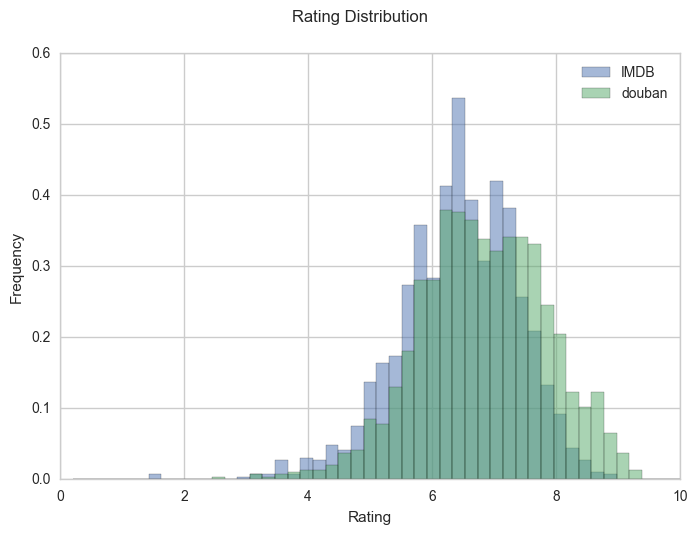

In [15]:
# 1. Why douban is higher?
# 2. Why the std is close to 1? (but IMDB < Douban, indicating a narrower distribution)
bins=linspace(0,10)
df['imdb_rating'].hist(bins=bins, alpha=0.5, normed=True, label = 'IMDB')
df['db_rating'].hist(bins=bins,alpha=0.5,  normed=True, label = 'douban')
plt_configure(xlabel='Rating',ylabel='Frequency', title='Rating Distribution', legend=True)

1. 两者大致分布正态分布，可以认为样本量基本足够
2. 这不是标准的正态分布，有偏度。原因？
3. 豆瓣电影偏高（相对有移动了）

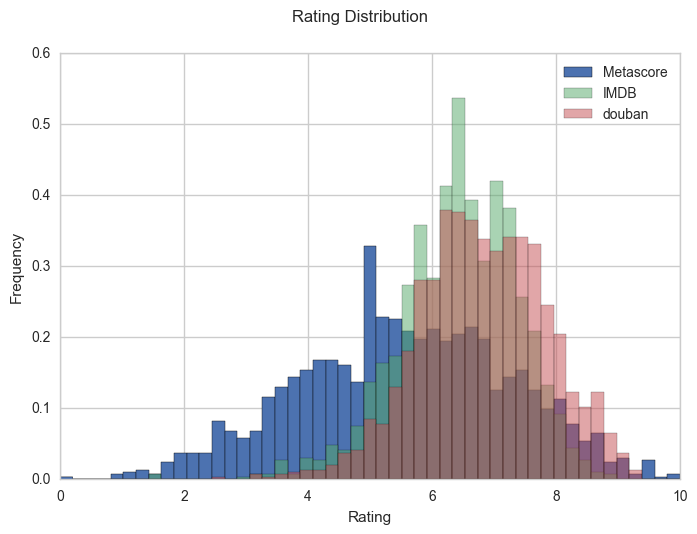

In [16]:
df['metascore'].hist(bins=bins, normed=True, label = 'Metascore')
df['imdb_rating'].hist(bins=bins, alpha=0.5, normed=True, label = 'IMDB')
df['db_rating'].hist(bins=bins,alpha=0.5,  normed=True, label = 'douban')
plt_configure(xlabel='Rating',ylabel='Frequency', title='Rating Distribution', legend=True)

并不是所有的影评分布都会类似. 比如Metascore的分布，就大为不同

Metascore的分数经过了人工的调整、加权，所以分布差别很大

## 3.2 Good Movies

Any your favorite?

### 3.2.1 Order by IMDB Rating

In [17]:
# Good Movies
# display(df.sort_values(by='imdb_rating',ascending=False).head(5))
movie_list(df.sort_values(by='imdb_rating',ascending=False))

### 3.2.2 Order by Douban Rating

In [18]:
movie_list(df.sort_values(by='db_rating',ascending=False))

## 3.3 Scatter Comparison

scatter,可以非常直观的比较两者的差别

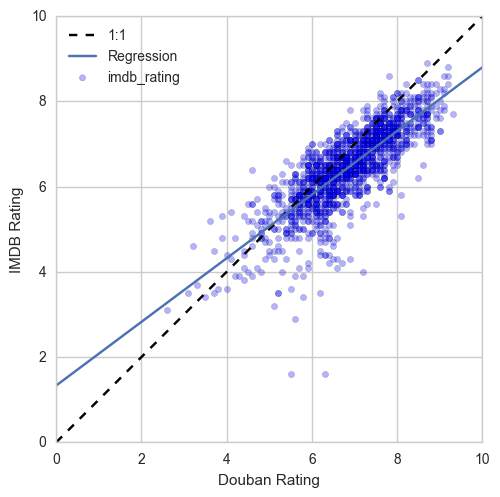

In [19]:
fig, _ , scatter_plot = plot_movie_scatter_comparison(df, title='')

In [20]:
turn_scatter_into_interactive(fig, scatter_plot, df, 'movie_compare_all.html')

对比回归线，可以看到
1. 并不是1:1的关系，斜率不同（原因？可能是打分制？），而且分数越高，差别越大

    - IMDB: 10星制。没有人会打10星  
    - 豆瓣：5星制。4星以上都会打5星
    
    豆瓣的打分制概念简单，不需要太精确，体验更好。

2. IMDB比豆瓣要齐整得多。豆瓣确实有一些电影，偏离回归线较大[(4,6)附近]

3. Play with the scatter, 发现“打分人数”的问题

## 3.4 Rating Number Problem

In [21]:
for min_ratings_number in [0, 1000,3000,5000,10000, 20000,40000]:
    min_ratings_number = min_ratings_number
    temp_df = df.query("(db_ratings_count > @min_ratings_number) & \
                   (imdb_ratings_count > @min_ratings_number)")
    title = 'Min Rating: ' + str(min_ratings_number)
    fig, fit_params, _ = plot_movie_scatter_comparison(temp_df, title=title)
    fig.set_size_inches(2.5,2.5)
    fig.show()
    print(min_ratings_number, fit_params[1], len(temp_df))
align_figures()

D:\Program Files\Anaconda3\lib\site-packages\matplotlib\figure.py:397: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


0 0.746613559846 1435
1000 0.761961689062 954
3000 0.779117292801 735
5000 0.794122490774 609
10000 0.809228311458 436
20000 0.785245079648 303
40000 0.782214462177 190


<img style="margin:0" align="left" src="data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAQsAAAEWCAYAAABxHbIXAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAPYQAAD2EBqD+naQAAIABJREFUeJzsvXl8VPW9//88c2afyb6ThWxAEsjCIigIKIILoNdvrfVW
q12ofdSlbm1vsbdaa21da6+tdbnV1tp7f721WhcEteCGYgQEwxoIBCb7PktmMvuc8/vjkwQiIAkG
EvA8H488Qs7MOec9hzmv836/P+/P+yOpqqqioaGhcRx0Y22AhobG6YEmFhoaGsNCEwsNDY1hoYmF
hobGsNDEQkNDY1hoYqGhoTEsNLHQ0NAYFppYaGhoDAtNLDQ0NIaFJhbjlGuvvZaSkhK+/vWvH/M9
t99+OyUlJdx5552D20pKSnj88ce/0Lk3bdpESUnJET/l5eUsXLiQn/zkJ3R3d4/omOFwmPvvv5/X
X399cNudd97JBRdc8IVs/aL85S9/4cILL6SyspKvfOUrvP/++2Nqz3hGP9YGaBwbWZbZtm0bHR0d
ZGRkDHktEAjw3nvvIUnSkO0vvPDCEe89ESRJ4uc//zllZWWD2/r6+tiyZQtPP/00DoeDv//978M+
XldXF3/5y1944IEHBrfdeOONfPOb3/zCtp4of/7zn3nkkUf4wQ9+wNSpU3nxxRe58cYb+etf/8qM
GTPGzK7xiiYW45iysjL279/Pm2++ecRN9e6772KxWEhISBiyvaKiYtTOX1RUdMTxzjnnHEKhEM88
8wz19fUUFRUN61hHm4KUm5s7KnaeCKFQiCeffJIVK1bw/e9/H4D58+fz7//+7/zhD3/g2WefHTPb
xitaGDKOsVgsLFy4kDfffPOI19asWcPFF1+MTjf0v/DwMGQgnKiurmbFihVUVVVx7rnn8sgjjxz1
5h0ucXFxAEO8mnXr1nHNNdcwY8YMysvLueSSS/jf//1fAFpaWli8eDGSJLFy5crB0GPlypUsWrRo
8BiLFi3i97//PQ899BDz5s2jsrKS7373uzQ0NAw5/8svv8yyZcuoqKjg8ssvp7q6mqlTp/LKK68M
uQ6Hh2efZdu2bXi9XhYvXjxk+5IlS9i4cSPhcPgEr86ZiyYW45ylS5dSU1NDR0fH4Dafz8f69etZ
tmzZsI7x4x//mFmzZvH0009z6aWX8swzz/CPf/zjuPvFYrEhPx6Ph7feeotnn32WyspKCgsLAXjv
vfe4+eabKS8v58knn+Txxx8nLy+P++67j+3bt5Oens7jjz+OqqrceOON/OEPfwCE2Hw2jHr++ec5
cOAADzzwAL/61a/YuXMnP/nJTwZff+WVV7jzzjuZOXMmTz75JBdddBE33XQTiqIMOc4LL7zAjTfe
eMzPVl9fD0B+fv6Q7RMnTiQWi9HY2Hjc6/NlQwtDxjkLFy7EYrEMCUXWrl1LamoqM2fOHNYxrrrq
Km644QYA5syZw9q1a3n33Xf52te+dsx9VFXl29/+9hEeSEJCAosXL+ZHP/rR4Lb6+nq+8pWvsHLl
ysFtVVVVzJkzh40bN1JRUUFpaSkAeXl5lJSUHPO8CQkJPPnkk4Mi0tDQwOOPP47H4yEhIYHf/e53
XHDBBdx7770AzJs3D1mW+e1vfzvkOMcLx7xeLwB2u33IdpvNBghB1hiKJhbjHJPJxPnnnz9ELNas
WcPSpUuHfYzKysohf2dmZhIIBI6737333ktZWRmxWIy3336bZ599lmuvvZabb755yPtWrFgBgN/v
5+DBgzQ0NLBz506AEbvz5eXlQ7yNzMxMQCR0PR4Pra2t3HbbbUP2Wb58OY8++uiIznO8MOyz4Z2G
JhanBUuXLuUHP/gBHR0dmEwmqqurueOOO4a1ryRJWCyWI7Z91m0/2n75+flMnToVEE9qg8HA448/
jtls5rvf/e7ge10uF3fffTdvv/02Op2OiRMnDno9I82NmM3mIX8P3LSKouB0OgFISUkZ8p7U1NQR
nQMOeRR9fX2DORg45FF81uPQ0MTitGD+/PlYrVbeeustLBYLOTk5g279qeSGG25g3bp1PPbYY5x3
3nkUFxcD8MMf/hCHw8Hzzz9PZWUlBoOBYDDICy+8MKrnH/AyPlvj0dPTM+JjDeRbGhoamDZt2uD2
hoYGDAbDmI7UjFc0X+s0wGg0snjxYt58803eeOMNli9fPiZ2yLLMPffcQzQa5b777hvcvnXrVi68
8EJmzZqFwWAAGCxuGvAsZFn+wufPzMwkLy+PdevWDdn+1ltvHZEoPR7Tp0/HbDbz1ltvDdm+du1a
Zs+ePfg5NA6heRanCZdccgnf//73kWWZu+66a9j7negQ6bH2q6qq4rLLLuPVV1/lrbfe4qKLLqK8
vJxVq1ZRVlZGZmYmW7Zs4b//+7/R6XT4/X7gkFtfXV1NYWHhCdeD3HLLLfz4xz/mnnvuYcmSJdTW
1vLEE08AQ4dyt23bRnJy8jE9BLPZzIoVK3jiiSfQ6/VMnz6dF198kV27dvE///M/J2TbmY7mWYxj
Dv/yz5s3j/j4eCZPnkxBQcGQ9xz+vqP9fbxjj/T1H/3oR9jtdh588EFCoRAPPvggFRUV3Hfffdx8
8828++67/PKXv+Tcc89ly5YtgBCLb3/726xdu5brr7+eWCx2xHmONpT6WZYvX869995LdXU1N9xw
A2vWrOFnP/sZqqoOjmSAGAEaEJFjcfPNN3PLLbfw6quvcsstt9DS0sJTTz1FVVXV5+73ZUXSuntr
nE6sXr2asrKyIYL53nvvccMNN/Dqq68yefLkMbTuzGZceRbhcJhLL72UzZs3D25rbm7m29/+NtOn
T2f58uVs2LBhDC3UGGtee+01rr/+el5//XU++eQTXnrpJe655x7mzJmjCcVJZtzkLMLhMHfccQf7
9+8fsv2mm26ipKSEl156iXXr1nHzzTfzxhtvDGbGNb5cPPTQQ/zmN7/hkUcewel0kpqayiWXXMIt
t9wy1qad8YwLsaivr+eHP/zhEdurq6tpamrihRdewGQy8b3vfY/q6mpefPHFIwqDNL4cJCQkDFZv
apxaxkUYsmnTJs455xz+/ve/D8nCb9++nalTp2IymQa3zZw5k5qamrEwU0PjS8248CyO1eClq6uL
9PT0IdtSUlKGTKrS0NA4NYwLz+JYBAIBjEbjkG1Go1GbPqyhMQaMC8/iWJhMJjwez5Bt4XD4iPkD
xyIajeLxeDCZTNrEII0vLYqiEAqFSEhIQK8/8Vt+XItFRkbGEaMj3d3dpKWlDWt/j8eDw+E4CZZp
aJx+5OfnHzEJbySMa7GorKzkj3/8I+FweDAc2bJlC7NmzRrW/gOJ0dTU1HE3izAUCtHW1kZWVtaQ
BO54YLzaNl7tgvFlWyQS4Wc/+xkffvghAJdddhlXXXXVF7ZrXIvF7NmzycrKYuXKldx444288847
7NixY0jT189jIPSw2+1fSFFPBn6/n7a2NhITE7FarWNtzhDGq23j1S4YP7aFQiGuvPJKVq1aBcCl
l17KD3/4Q5qbm79wKD7uAvnD5wbodDqeeOIJurq6uOKKK1i1ahV/+MMftIIsDY2jEIlEjhCKF198
8QvlKQ5n3HkWtbW1Q/7Ozc3lr3/96xhZo6Fx+qDX65kyZQqrVq0aFIrPjiZ+oeOP2pE0NDTGFEmS
eOihh5g6dSpXX331qAoFaGKhoXFGIUkS3/rWt07KscddzkJDQ2N8oomFhobGsNDEQkPjNCMcDhON
Rk/5eTWx0NA4jQiFQnz1q1/lmmuuOeWCoSU4NTROEz5bcDVnzpxhrx8zGmiehYbGacDRKjNPdQMo
TSw0NMY5RxOK0S64Gg6aWGhojGPGi1CAJhYaGuOa733ve+NCKEATCw2Ncc1tt91GcnLymAsFaKMh
GhrjmunTp1N

对比上面这几张图，可以发现随着评分人数的增加，偏离逐渐收窄，但并不迅速收窄

一直到4W人以上，豆瓣和IMDB才算均衡。也就是说，
- 部分电影的偏离，确实是由于看的人很少，打分不客观引起（打分样本过少）
- 部分偏离的电影，是有相当一部分人观看的 （>3K），这个现象确实存在

### 3.4.1 Ratings Number Distribution (Optional)

In [22]:
# # This plot is not very informative, what can I do?
# # Why is this kind distribution? -> Poisson
# fig=plt.figure()
# df['imdb_ratings_count'].hist(bins=50, alpha=0.5, figsize=(4,3))
# plt_configure(title='IMDB', xlabel='rating_number', ylabel='Frequency')
# fig=plt.figure()
# df['db_ratings_count'].hist(bins=50, alpha=0.5, figsize=(4,3))
# plt_configure(title='Douban', xlabel='rating_number', ylabel='Frequency')
# align_figures()

In [23]:
# fig=plt.figure()
# df['imdb_ratings_count'].hist(bins=linspace(0,100000), alpha=0.5, figsize=(4,3))
# plt_configure(title='IMDB', xlabel='rating_number', ylabel='Frequency')
# fig=plt.figure()
# df['db_ratings_count'].hist(bins=linspace(0,50000), alpha=0.5, figsize=(4,3))
# plt_configure(title='Douban', xlabel='rating_number', ylabel='Frequency')
# align_figures()

### 3.4.2 Correlation between Rating and Rating Numbers (Optional)

In [24]:
# df.plot(kind='scatter', x='db_ratings_count', y='imdb_ratings_count', alpha=0.30)
# plt_configure(title='Douban ratings count vs. IMDB ratings count')

In [25]:
# fig, ax = plt.subplots()
# df.plot(ax=ax, kind='scatter', x='imdb_rating', y='imdb_ratings_count', alpha=0.30)
# plt_configure(title='IMDB rating vs. ratings count', figsize=(4,3))
# fig, ax = plt.subplots()
# df.plot(ax=ax, kind='scatter', x='db_rating', y='db_ratings_count', alpha=0.30)
# plt_configure(title='Douban rating vs. ratings count', figsize=(4,3))
# align_figures()

# 4. Comparison among Popular Movies

重新选择评分人数更多的电影，更有说服力

## 4.1 Overviews

In [26]:
min_ratings_number = 2000
df = df.query("(db_ratings_count > @min_ratings_number) & \
               (imdb_ratings_count > @min_ratings_number)")

df['diff']=df['db_rating']-df['imdb_rating']
df['imdb_rank'] = df['imdb_rating'].rank()/len(df)*100
df['db_rank'] = df['db_rating'].rank()/len(df)*100
df['rank_diff']=df['db_rank']-df['imdb_rank']
df.describe()

,imdb_rating,metascore,imdb_ratings_count,db_rating,db_ratings_count,diff,imdb_rank,db_rank,rank_diff
count,822.000000,822.000000,8.220000e+02,822.000000,822.000000,822.000000,822.000000,822.000000,8.220000e+02
mean,6.636375,5.656204,1.019389e+05,7.013869,37004.064477,0.377494,50.060827,50.060827,2.182628e-15
std,0.878254,1.682859,1.321592e+05,0.914960,60361.058882,0.553247,28.863203,28.867706,1.687155e+01
min,3.400000,1.100000,2.080000e+03,4.100000,2006.000000,-1.800000,0.121655,0.182482,-4.993917e+01
25%,6.100000,4.500000,2.290700e+04,6.400000,5215.250000,0.000000,24.209246,27.068127,-9.549878e+00
50%,6.650000,5.700000,5.627600e+04,7.000000,12622.500000,0.400000,50.152068,49.756691,-3.649635e-01
75%,7.200000,6.800000,1.286085e+05,7.600000,40348.750000,0.700000,73.236010,73.236010,9.732360e+00
max,8.900000,10.000000,1.255291e+06,9.200000,586362.000000,2.700000,100.000000,99.878345,6.180049e+01


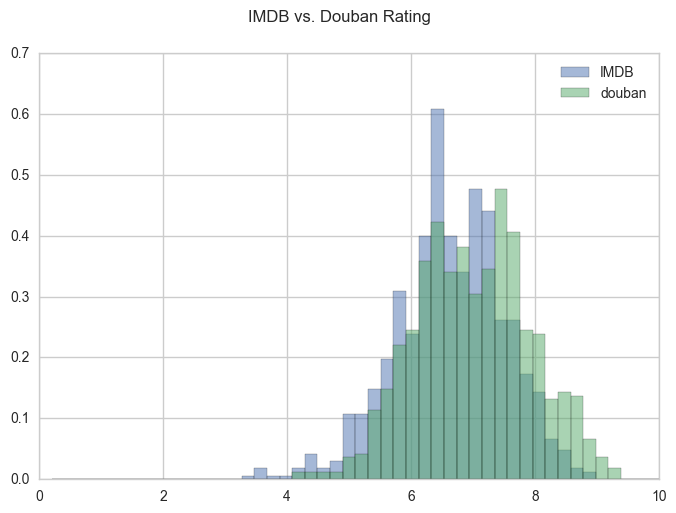

In [27]:
bins=linspace(0,10)
df['imdb_rating'].hist(bins=bins, alpha=0.5, normed=True, label = 'IMDB')
df['db_rating'].hist(bins=bins,alpha=0.5, normed=True, label = 'douban')
plt_configure(title='IMDB vs. Douban Rating', legend=True)

### 4.1.1 Best Movies

In [28]:
# df.sort_values(by='imdb_rating',ascending=False).head()
movie_list(df.sort_values(by='imdb_rating',ascending=False)[:20])

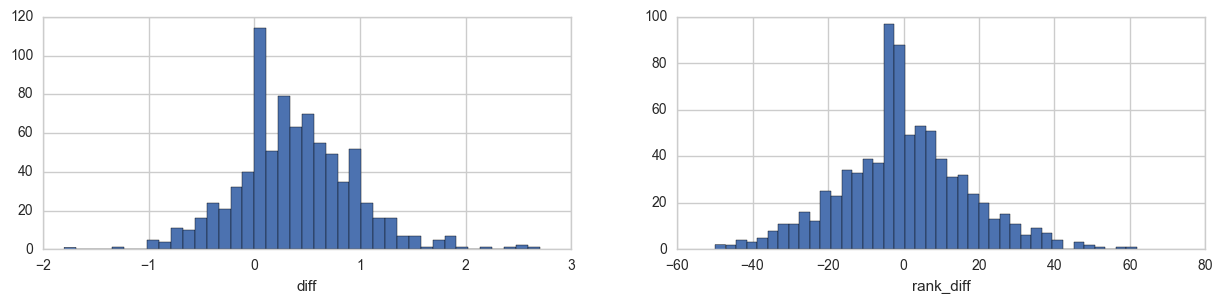

In [29]:
plt.subplot(1,2,1)
df['diff'].hist(bins=40,figsize=(15, 3))
plt.xlabel('diff')
plt.subplot(1,2,2)
df['rank_diff'].hist(bins=40)
plt.xlabel('rank_diff')

## 4.2 Scatter Comparison

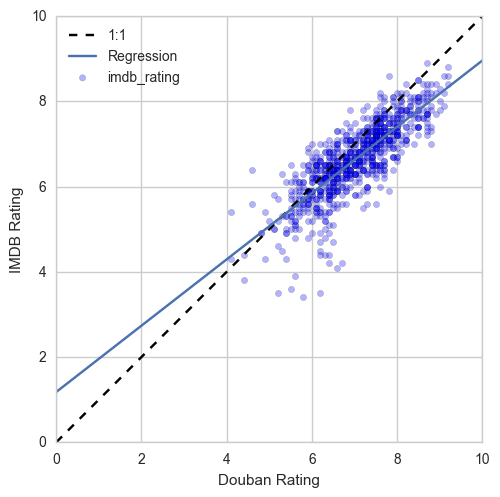

In [30]:
fig, _ , scatter_plot = plot_movie_scatter_comparison(df, title='')

In [31]:
turn_scatter_into_interactive(fig, scatter_plot, df, 'movie_compare.html')

1. 对比前后scatter plot, 总体趋势是不变的
2. Play with the Scatter Plot， 看看有哪些电影差别很大:

    1. 回归线以上，IMDB >> 豆瓣；回归线以下，豆瓣 >> IMDB
    2. 总体而言，豆瓣评分确实更分散，(7,4.5)附近的一个cluster, 可以算作典型的偏离
    3. 这些偏离的电影，有何规律？

## 4.3 Absolute Difference

先查看绝对分值差别大的电影， 再看相对差别大的电影（类似于回归线）

### 4.3.1 豆瓣 >> IMDB

In [32]:
# df.sort_values(by='diff',ascending=False).head()
movie_list(df.sort_values(by='diff',ascending=False))

### 4.3.2 IMDB >> 豆瓣

In [33]:
# df.sort_values(by='diff',ascending=False).head()
movie_list(df.sort_values(by='diff',ascending=True))

## 4.4 Rank Difference

### 4.4.1 Douban >> IMDB

In [34]:
# df.sort_values(by='rank_diff',ascending=False).head()
movie_list(df.sort_values(by='rank_diff',ascending=False))

### 4.4.1 IMDB >> 豆瓣

In [35]:
movie_list(df.sort_values(by='rank_diff',ascending=True))

我观察到的规律: 似乎很多动画的评分，差别很大，例如：
1. 蓝精灵
2. Rio
3. 冰川时代
4. 疯狂原始人

那么，是不是存在某类电影，评分差别会很大？

接下来，按类别分析

# 5. Genre Comparison

In [36]:
def category_overview(df, category):   
    sub_df = df[df['genre'].str.contains(category)]
    fig, _ , scatter_plot = plot_movie_scatter_comparison(sub_df)
    print(len(sub_df))

In [37]:
for category in ["Romance", "Drama", "Action", 'Sci-Fi', 'Animation', 'Mystery', 'Crime', 'Adventure', 'Documentary', 'Comedy']:
    category_overview(df, category)
    plt_configure(title=category)
    plt.gcf().set_size_inches(2.5,2.5)
align_figures()

143
420
212
61
51
67
127
150
24
283


<img style="margin:0" align="left" src="data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAQsAAAEWCAYAAABxHbIXAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAPYQAAD2EBqD+naQAAIABJREFUeJzsnXd4FOXah+/tm2TTeyAhJIQklIQQIHQwCioYBAQLior6
IVaK6EFFRESKWPAYRZCDCscjCBgRUIpKUXqvCZBAEtJ73V6+P5ashARIIA2Y+7q8ZGZn3nl2svvb
d573KSKLxWJBQEBA4DqIm9sAAQGBWwNBLAQEBOqEIBYCAgJ1QhALAQGBOiGIhYCAQJ0QxEJAQKBO
CGIhICBQJwSxEBAQqBOCWAgICNQJaXMbINCwjB07lgMHDlTbJxKJsLe3JzAwkKeeeophw4Y1k3UC
tzKCWNyGdOjQgZkzZ9q2TSYT2dnZfPfdd7zxxhu4uLjQv3//5jNQ4JZEEIvbEJVKRURERLV9UVFR
9O/fn169epGQkCCIhUC9EXwWdxByuRy5XI5IJAJAr9fzxRdfcP/99xMREcG9997L119/zeW5hWPH
jmXGjBksWrSI/v3706VLF8aPH09hYSFr165l8ODBREVFMW7cOLKysmznmc1mlixZQlxcHJGRkURF
RfHoo4+yb98+2zHx8fEMHjyYHTt2MGzYMDp37sy9997LunXrqtmdn5/Pv/71L3r37k3Xrl0ZO3Ys
R48etb1usVhYsmQJgwcPto3x3//+t7Fu4x2LMLO4DbFYLJhMJtu2yWQiIyODL774ArVazYMPPgjA
888/z/Hjx3nllVcIDQ1l7969LFy4kIsXLzJr1izb+Rs3bqRjx47MmTOH7Oxs3nvvPZ544gmUSiXT
pk1Do9Ewffp0Zs2axVdffQXAggULWLlyJVOnTiU0NJTc3Fzi4+OZOHEiO3bsQKFQAFYheP/993nx
xRfx9fVl6dKlTJs2jYiICNq2bYtarebRRx/FYrHwxhtv4O3tzbJly3jmmWf4+eefCQgI4N133yUh
IYEJEyYQFRXF/v37mTNnDuXl5bzwwgtNeOdvcywCtxVPPPGEJTQ0tMZ/YWFhlgcffNCyZcsWi8Vi
sWzfvt0SGhpq+fXXX6ud/+WXX1rCwsIsycnJtvEiIyMt5eXltmOee+45S1hYmCUjI8O27/3337d0
797dtj116lTLihUrqo29ZcsWS1hYmOXYsWMWi8Vi+fzzzy1hYWGWvXv32o7JysqyhIaGWr755huL
xWKxrFixwhIeHm5JSkqyHaPVai333XefZfXq1ZYLFy5YwsLCLEuXLq12rYULF1oiIyMtJSUl9b6H
ArUjzCxuQzp27Mj777+PxWIhLy+PTz/9FKPRyMKFCwkMDATgwIEDSKVS7rvvvmrnDhs2jM8++4z9
+/cTHBwMQFBQECqVynaMh4cHrq6utGrVyrbPxcWF8vJy2/aCBQsAKCoq4sKFC6SlpbFt2zbA+vhz
OV26dLH928fHBwC1Wg3A4cOHad26NaGhobZjFAoFv/32GwArV64EYODAgdVmU3fddReLFi3i4MGD
3H333XW+dwJXRxCL2xAHBwc6dOgAWIUjIiKCYcOGMW7cOBISEnBxcaG0tBRXV1eb/6IKT09PgGpf
/MuFogo7O7tr2nDixAnee+89Tp48iZ2dHSEhIfj6+gJU84kAtkcSwGaP2WwGoKSkBDc3t6tep6Sk
BIvFwtChQ2u8JhKJyMvLu6adAnVHEIs7AHd3d2bMmMHEiROZPXs2H330Ec7OzhQXF2OxWKoJRtWX
y9XV9YavV1FRwf/93/8RHh7Or7/+SlBQEAA7duxgy5Yt9RrL0dGRzMzMGvuPHDmCk5MTjo6OiEQi
li9fjr29fY3jqgRK4OYRVkPuEO6991769evHxo0bOXjwIN27d8doNNqm81WsW7cOkUhEdHT0DV/r
/PnzlJSUMHbsWJtQAOzcuRP4Z9ZQF7p168bFixdJSUmx7dPpdLzyyiusXbuW7t27Y7FYKCoqomPH
jrb/CgoKWLhwISUlJTf8PgSqI8ws7iDeeust4uLimD17Nj/99BMxMTG888475ObmEhYWxr59+1i6
dCkjRoyo9iWvL1U+jq+++gqJRIJUKmXz5s2sWbMGAI1GU+exRo4cyYoVK3jhhRd45ZVXcHV15bvv
vsNgMPDEE0/g5+fHsGHDeOedd8jIyKBTp06cP3+ehQsX4u/vT9u2bW/4fQhUR5hZ3IZc6Yeoom3b
tjz55JOcOXOGH374gSVLlvDII4/w3Xff8fzzz7NlyxamTp3KnDlzrjvetfapVCoWLVqExWJh0qRJ
/Otf/yInJ4fvv/8eBwcHDh48eN1xqvY7ODjw/fffExkZyezZs5k8eTIWi4UVK1bg5+cHwLx58xg3
bhyrVq3iueeeY8mSJTzwwAMsW7bsqvdCoP6ILFd6mwQEBARqoUXNLPR6PXFxcdUSoTIyMhg3bhxR
UVE88MAD7Nq1qxktFBC4c2kxYqHX65kyZQrJycnV9r/00kt4eXmxdu1ahg0bxssvv0xOTk4zWSkg
cOfSIsQiJSWFhx9+mIyMjGr79+zZYws9DgoKYvz48XTp0sXmKBMQEGg6WoRY7N+/n169erFq1apq
ATvHjx+nY8eO1YJ2oqOjqyURCQgINA0tYun0scceq3V/fn4+Xl5e1fa5u7uTm5vbFGYJCAhcRouY
WVwNjUaDXC6vtk8ul9fILRAQEGh8WsTM4mooFApKS0ur7dPr9SiVyjqdbzQaKS0tRaFQIBa3aF0U
EGg0zGYzOp0OZ2dnpNIb/8q3aLHw9vausTpSUFBgS3a6HqWlpaSmpjaCZQICtx6BgYG4u7vf8Pkt
WiwiIyP5+uuv0ev1tseRQ4cO0a1btzqdX+UY9fDwqDVzsjnR6XRkZ2fj6+tbzYHbEmiptrVUu6Bl
2WYwGJg+fTp///03YC078Mgjj9y0XS1aLHr06IGvry/Tpk3jxRdf5M8//+TEiRPMmzevTudXPXqo
VKqbUtTGQK1Wk52djYuLS63Zks1JS7WtpdoFLcc2nU7H6NGjWb9+PQBxcXG89tprZGRk3PSjeIt7
kL88ll8sFvPll1+Sn5/PQw89xPr16/niiy9sBVIEBAT+wWAw1BCKNWvW3JSf4nJa3MwiMTGx2ra/
vz8rVqxoJmsEBG4dpFIpoaGhrF+/3iYUV64m3tT4DTaSgIBAsyISifjwww/p2LEjY8aMaVChAEEs
BARuK0QiEU8//XSjjN3ifBYCAgItE0EsBAQE6oQgFgICtxh6vR6j0djk1xXEQkDgFkKn0zFq1Cge
f/zxJhcMwcEpIHCLcGXAVUxMDFOmTGmy6wszCwGBW4DaIjNffvnlJrVBEItbmNpqll6NgwcPcs89
9zSBVQINTW1C0dABV3VBEItblKvVLK2NM2fOMGnSpBptAwVaPi1FKEAQi1uSq9UsrY2VK1fy2GOP
4eHh0QSWCTQ048ePbxFCAYKDs1b27dt3zdfbtWt3zSzWwsLC6/7id+7c+YZsg39qlk6aNInIyMhq
r4WFhTFv3jyGDx8OwN9//82HH35IeXk58fHxN3xNgeZh0qRJbNiwgT59+jSrUIAgFrXSs2fPa77+
448/Mnr06Ku+/ueff/Lwww9fc4zKysobsg2uXrMUYNeuXTg6Otq2qwQiISHhhq8n0HxERUWxZ88e
AgMDb0goSsp1JOy8QFTAzXdmE8TiNqOl1e0QuHnat29/Q+elZpfx/n/2IsFIVID3TdshiEUt7N27
95qvt2vX7pqvx8bGXncMAYHGZP+pHD76/iAanQlfV1mDjCmIRS3ExMTc1Pnu7u7X/YVXq9U3dQ0B
gdqwWCwkbE/m242nsVhAKhHx0F1BwI0/9lYhiIWAQDOj0+lIT08nJCTkpsYxGE3Erz7GnwcvAuDk
IOetp3vg4wy

可以发现，动画和其他类别，显著不同。具体画如下

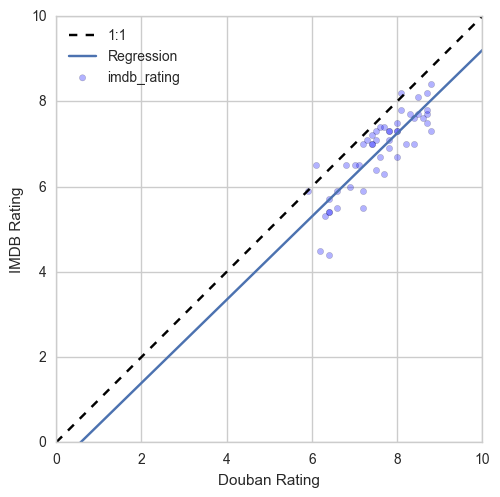

In [38]:
sub_df = df[df['genre'].str.contains('Animation')]
fig, _ , scatter_plot = plot_movie_scatter_comparison(sub_df)

In [39]:
turn_scatter_into_interactive(fig, scatter_plot, sub_df, 'animation_movies.html')